In [1]:
import lusid
import lusid.models as models
import os
import json
from lusidjam import RefreshingToken
import uuid
from datetime import datetime
import pytz
from collections import namedtuple

LUSID_INSTRUMENT_IDENTIFIER = "Instrument/default/LusidInstrumentId"

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)

In [2]:
# create instruments

instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"}
]

figis_to_create = {
    i["Figi"]:models.InstrumentDefinition(
        name=i["Name"], 
        identifiers={"Figi": models.InstrumentIdValue(
            value=i["Figi"])}
    ) for i in instruments 
}

upsert_response = api_factory.build(lusid.api.InstrumentsApi).upsert_instruments(request_body=figis_to_create)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)

ids = api_factory.build(lusid.api.InstrumentsApi).get_instruments(
    identifier_type="Figi", 
    request_body=[i["Figi"] for i in instruments])

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [3]:
def build_transaction(trade_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="StockIn",
        instrument_identifiers={LUSID_INSTRUMENT_IDENTIFIER: trade_spec.id},
        transaction_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        transaction_price=models.TransactionPrice(
            price=trade_spec.price),
        total_consideration=models.CurrencyAndAmount(
            amount=100 * trade_spec.price, 
            currency="GBP"),
        source="Client"
    )

scope = "finbourne"
portfolio_code = "valuationPortfolio"
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)

request = models.CreateTransactionPortfolioRequest(
    display_name=portfolio_code,
    code=portfolio_code,
    base_currency="GBP",
    created=effective_date
)

try:

    #  create the portfolio
    result = api_factory.build(lusid.api.TransactionPortfoliosApi).create_portfolio(
        scope=scope, 
        create_transaction_portfolio_request=request)

except lusid.ApiException as e:
    print(json.loads(e.body)["title"])
    
TransactionSpec = namedtuple('TransactionSpec', 'id price trade_date')
transaction_specs = [
    TransactionSpec(instrument_ids[0], 101, effective_date),
    TransactionSpec(instrument_ids[1], 102, effective_date),
    TransactionSpec(instrument_ids[2], 103, effective_date)
]
transaction_specs.sort(key=lambda ts: ts.id)

new_transactions = list(map(build_transaction, transaction_specs))

#   add initial batch of trades
add_transactions_result = api_factory.build(lusid.api.TransactionPortfoliosApi).upsert_transactions(
    scope=scope, 
    code=portfolio_code, 
    transaction_request=new_transactions)

Could not create a portfolio with id valuationPortfolio because it already exists in scope finbourne.


In [4]:
# Create quote requests
instrument_quotes = {
    instrument_ids[i]: models.UpsertQuoteRequest(
        quote_id=models.QuoteId(
            quote_series_id=models.QuoteSeriesId(
                provider='DataScope',
                instrument_id=instrument_ids[i],
                instrument_id_type='LusidInstrumentId',
                quote_type='Price',
                field='Mid'),
            effective_at=effective_date
        ),
        metric_value=models.MetricValue(
            value=i*100,
            unit="GBP"),
        lineage='InternalSystem') for i in range(1,4)
    }

# Upsert the quotes into LUSID
response = api_factory.build(lusid.api.QuotesApi).upsert_quotes(
    scope=scope,
    request_body=instrument_quotes)

In [5]:
# Create a recipe to perform a valuation
configuration_recipe = models.ConfigurationRecipe(
    scope="User",
    code='quotes_recipe',
    market=models.MarketContext(
        market_rules=[
            models.MarketDataKeyRule(
               key='Equity.LusidInstrumentId.*',
               supplier='DataScope',
               data_scope=scope,
               quote_type='Price',
               field='Mid')
        ],
        suppliers=models.MarketContextSuppliers(
            commodity='DataScope',
            credit='DataScope',
            equity='DataScope',
            fx='DataScope',
            rates='DataScope'),
        options=models.MarketOptions(
            default_supplier='DataScope',
            default_instrument_code_type='LusidInstrumentId',
            default_scope=scope)
        )
    )

upsert_configuration_recipe_response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request = models.UpsertRecipeRequest(
    configuration_recipe = configuration_recipe
    )
)

In [6]:
# Create the valuation request
valuation_request = models.ValuationRequest(
    recipe_id= models.ResourceId(scope="User", code='quotes_recipe'),
    metrics=[
        models.AggregateSpec("Instrument/default/Name", "Value"),
        models.AggregateSpec("Holding/default/PV", "Proportion"),
        models.AggregateSpec("Holding/default/PV", "Sum")
    ],
    group_by=["Instrument/default/Name"],
    portfolio_entity_ids=[models.PortfolioEntityId(scope=scope, code="valuationPortfolio")],
    valuation_schedule=models.ValuationSchedule(effective_at=effective_date.isoformat())
)

# Perform a valuation
valuation = api_factory.build(lusid.api.AggregationApi).get_valuation(
    valuation_request=valuation_request)

In [7]:
for item in valuation.data:
    print("\t{}\t{}\t{}".format(
        item["Instrument/default/Name"], 
        item["Proportion(Holding/default/PV)"], 
        item["Sum(Holding/default/PV)"]))

	SAINSBURY (J) PLC	0.3	30000.0
	VODAFONE GROUP PLC	0.2	20000.0
	NATIONAL GRID PLC	0.4	40000.0
	BARCLAYS PLC	0.1	10000.0


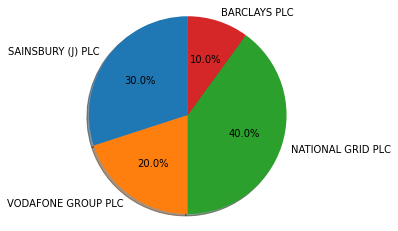

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []
for item in valuation.data:
    labels.append(item["Instrument/default/Name"])
    values.append(item["Proportion(Holding/default/PV)"] * 100)
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()